# An introduction to using MMS MEC data files

### Quaternion math requires the latest version of SpacePy
### https://sourceforge.net/p/spacepy/code/ci/master/tree/ or https://github.com/spacepy/spacepy

Anything after git commit 2a287d40119871c579aa5a19b989161618b85a3d will work.

*We also note that MEC files with a major version number of 1 (i.e. v1.x.x) give the quaternions to rotate the frame.
MEC files with a major version number of >=2 (i.e. 2.x.x) give the quaternion to rotate the vector.*

*If using the version 1.x.x files the expected vector rotation can be found by taking the conjugates of each quaternion.*

In [1]:
#start with some necessary module imports
import os
import numpy as np
import spacepy.datamodel as dm
import spacepy.toolbox as tb
import matplotlib.dates as mpd

#now some plotting setup, first we turn on "magic" inline plotting in the ipython notebook
%matplotlib inline
import matplotlib.pyplot as plt #imports plot library
import spacepy.plot as splot #gets spacepy plot tools and style sheets

First let's check whether we have the data file to work on...
If the named file isn't in this directory then we'll attempt to download it from the MMS SDC

Note that at the time of writing these files are not yet publicly available, so the download will fail. To reproduce this analysis the 

In [2]:
fname = 'mms1_mec_brst_l2_epht89d_20160301002916_v2.1.0.cdf'
if not os.path.isfile(fname):
    import urllib
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, fname])
    urllib.urlretrieve(dataurl, filename=fname)

In [3]:
mmsdata = dm.fromCDF(fname)

### Browse the data
To look at all the variables in a CDF loaded using SpacePy's datamodel we can just call the *tree* method. By setting the *verbose* keyword to **True** we can see the dimensions of each variable, and by setting the *attrs* keyword to **True** we'd be able to display the metadata associated with each variable.

In [4]:
mmsdata.tree(verbose=True)

+
|____3vec_representation (spacepy.pycdf.VarCopy (3,))
|____Epoch (spacepy.pycdf.VarCopy (2167,))
|____mms1_mec_L_phase (spacepy.pycdf.VarCopy (2167, 1))
|____mms1_mec_L_vec (spacepy.pycdf.VarCopy (2167, 2))
|____mms1_mec_L_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_P_phase (spacepy.pycdf.VarCopy (2167, 1))
|____mms1_mec_P_vec (spacepy.pycdf.VarCopy (2167, 2))
|____mms1_mec_P_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_Z_phase (spacepy.pycdf.VarCopy (2167, 1))
|____mms1_mec_Z_vec (spacepy.pycdf.VarCopy (2167, 2))
|____mms1_mec_Z_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_bfn_gsm (spacepy.pycdf.VarCopy (2167, 4))
|____mms1_mec_bfn_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bfs_gsm (spacepy.pycdf.VarCopy (2167, 4))
|____mms1_mec_bfs_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bmin_gsm (spacepy.pycdf.VarCopy (2167, 4))
|____mms1_mec_bmin_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bsc_gsm (spacepy.pycdf.VarCopy (2167, 4))
|____mms1

### To view metadata we just ask for the "attrs" of the variable
As noted above, the names of variable attributes can be visualized by *tree* when we add the *attrs* keyword.

In [5]:
print(mmsdata['mms1_mec_quat_eci_to_gse'].attrs)

{'FIELDNAM': 'mms1_mec_quat_eci_to_gse', 'VAR_TYPE': 'data', 'FORMAT': 'F18.6', 'VALIDMIN': -100000.0, 'COORDINATE_SYSTEM': 'GEI', 'REPRESENTATION_1': 'quaternion_representation', 'CATDESC': 'Quaternion rotation from GEI/J2000 to GSE (ECI to GSE). ((qx,qy,qz), qw)', 'SI_CONVERSION': ' > ', 'DEPEND_0': 'Epoch', 'VALIDMAX': 100000.0, 'DISPLAY_TYPE': 'time_series', 'FILLVAL': -9.9999999999999996e+30, 'UNITS': ' ', 'SCALETYP': 'linear', 'TO_COORDINATE_SYSTEM': 'GSE', 'LABL_PTR_1': 'mms1_mec_quat_eci_to_gse_label'}


To get a "prettier" display of the attributes, we can iterate over the members and print the attribute name and contents.

In [6]:
for key, value in mmsdata['mms1_mec_quat_eci_to_gse'].attrs.items():
    print('{0}: {1}'.format(key, value))

FIELDNAM: mms1_mec_quat_eci_to_gse
VAR_TYPE: data
FORMAT: F18.6
VALIDMIN: -100000.0
COORDINATE_SYSTEM: GEI
REPRESENTATION_1: quaternion_representation
CATDESC: Quaternion rotation from GEI/J2000 to GSE (ECI to GSE). ((qx,qy,qz), qw)
SI_CONVERSION:  > 
DEPEND_0: Epoch
VALIDMAX: 100000.0
DISPLAY_TYPE: time_series
FILLVAL: -1e+31
UNITS:  
SCALETYP: linear
TO_COORDINATE_SYSTEM: GSE
LABL_PTR_1: mms1_mec_quat_eci_to_gse_label


### So how do we use these quaternions?
The first test is to transform a set of known positions from one coordinate system to another. Here we'll go from GSE to GSM. We note that these values are not calculated with quaternions, but with rotation matrices in LANLGeoMag's CTrans routines. LANLGeoMag is available on github at: https://github.com/drsteve/LANLGeoMag

So let's take the mms1_mec_r_gse position vectors and use the quaternions to rotate from GSE to GSM. Then we'll compare to the GSM values in the files to ensure we've done this correctly.

All the quaternions are given as eci_to*_targetsystem* . So to get from GSE to GSM, we need to take the following steps:
 - Take the conjugate of the ECI->GSE quaternion, giving a GSE->ECI quaternion.
 - Multiply the ECI->GSM quaternion by the GSE->ECI quaternion (Note the order is mult(rot2, rot1), where rot1 is the first transformation you want to make).
 - Use the resultant quaternion to rotate the vectors into the target system.

In [7]:
quat_gse_to_eci = tb.quaternionConjugate(mmsdata['mms1_mec_quat_eci_to_gse'])
quat_gse_to_gsm = tb.quaternionMultiply(mmsdata['mms1_mec_quat_eci_to_gsm'], quat_gse_to_eci)

We know that GSE and GSM share the X-axis, so let's verify that the X axis is the same. We'll also look at the Z-axis, which should be different, though not radically so.

In [8]:
print('X = {0}'.format(tb.quaternionRotateVector(quat_gse_to_gsm[0], [1,0,0])))
print('Y = {0}'.format(tb.quaternionRotateVector(quat_gse_to_gsm[0], [0,0,1])))
print('and the quaternion we used for this is\n({0})'.format(quat_gse_to_gsm[0]))

X = [  1.00000000e+00  -4.59362263e-17  -4.17339550e-17]
Y = [  1.17086081e-17  -5.20732692e-01   8.53719781e-01]
and the quaternion we used for this is
([  2.70444282e-01   1.38777878e-17  -2.77555756e-17   9.62735628e-01])


It's important to note here that there are two conventions for the representation of quaternions. Quaternions have three vector parts *(i,j,k)* and a scalar part *(w)*, thus the scalar part can be the first, or last, element; we store the scalar part in the final element of a 1x4 array.

### Comparing the computed positions
Since that all looks about right, let's rotate the first three elements of mms1_mec_r_gse into GSM and compare to mms1_mec_r_gsm

In [9]:
myRgsm = tb.quaternionRotateVector(quat_gse_to_gsm[:3], mmsdata['mms1_mec_r_gse'][:3])
print(myRgsm - mmsdata['mms1_mec_r_gsm'][:3]) #should all be approx. zero

[[  3.63797881e-12  -2.91038305e-11  -2.18278728e-11]
 [  3.63797881e-12   7.27595761e-12   7.27595761e-12]
 [  3.63797881e-12   7.27595761e-12   0.00000000e+00]]


The differences are all better than machine precision. So, now that we've demonstrated how to use the quaternions to get from one system to another, let's get some actual data and transform it from satellite coordinates into a geophysical system.

Again, we'll need to grab a data file.

*Same caveats as above: at the time of writing these data files are only available to the MMS team.*

In [10]:
fname = 'mms1_dfg_brst_l1b_20160301002915_v1.19.0.cdf'
if not os.path.isfile(fname):
    import urllib
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, fname])
    urllib.urlretrieve(dataurl, filename=fname)




In [11]:
#use SpacePy's datamodel for a convenient read -- a more direct interface to the CDF library is in spacepy.pycdf
fields = dm.fromCDF(fname)

In [12]:
#extract the indices in the FIELDS file that are in the time-range given by the MEC file
inds = tb.tOverlapHalf(mmsdata['Epoch'], fields['Epoch'])

### Explore the data file, then visualize the B-field

In [13]:
%matplotlib inline
#"magic" inline plotting in the ipython notebook
import matplotlib.pyplot as plt #imports plot library

In [14]:
fields.tree()

+
|____Epoch
|____label_b_bcs
|____label_b_omb
|____mms1_dfg_brst_bcs
|____mms1_dfg_brst_etemp
|____mms1_dfg_brst_hirange
|____mms1_dfg_brst_l1a_mode
|____mms1_dfg_brst_l1b_flag
|____mms1_dfg_brst_omb
|____mms1_dfg_brst_rate
|____mms1_dfg_brst_stemp


In [15]:
for key, value in fields['mms1_dfg_brst_bcs'].attrs.items():
    print('{0}: {1}'.format(key, value))

FIELDNAM: Magnetic field vector in BCS plus Btotal (128 S/s)
VAR_TYPE: data
FORMAT: E13.5
LABL_PTR_1: label_b_bcs
CATDESC: Magnetic field vector in Body Coordinate System cartesian coordinates plus Btotal (128 S/s)
UNITS: nT
DEPEND_0: Epoch
VALIDMAX: [ 20000.  20000.  20000.  20000.]
DISPLAY_TYPE: time_series
FILLVAL: -9.99999984824e+30
LABLAXIS: mms1_dfg_brst_bcs
SCALETYP: linear
VALIDMIN: [-20000. -20000. -20000.     -0.]


In [16]:
npts = 3000 #120
tt = mpd.date2num(mmsdata['Epoch'][:npts])
fieldstt = mpd.date2num(fields['Epoch'])

We're looking at a few seconds of finely sampled B-field data, so let's just do a linear interpolation on the samples to get the
data at the sample times in the MEC file.

In [17]:
fieldsBCS = np.empty([len(tt), 3])
fieldsBCS[:,0] = tb.interpol(tt, fieldstt, fields['mms1_dfg_brst_bcs'][:,0], left=np.nan, right=np.nan)
fieldsBCS[:,1] = tb.interpol(tt, fieldstt, fields['mms1_dfg_brst_bcs'][:,1], left=np.nan, right=np.nan)
fieldsBCS[:,2] = tb.interpol(tt, fieldstt, fields['mms1_dfg_brst_bcs'][:,2], left=np.nan, right=np.nan)
mag = tb.interpol(tt, fieldstt, fields['mms1_dfg_brst_bcs'][:,3])

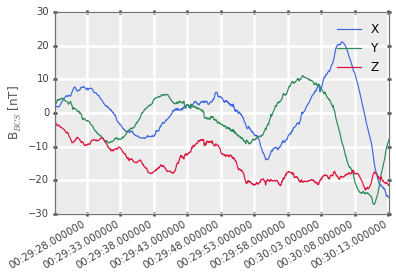

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
lObj = ax.plot(mmsdata['Epoch'][:npts], fieldsBCS)
ax.set_ylabel('B$_{BCS}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])



And now the conversion of the field vector from BCS to GSM

In [19]:
quat_bcs_to_eci = tb.quaternionConjugate(mmsdata['mms1_mec_quat_eci_to_bcs'])
quat_bcs_to_gsm = tb.quaternionMultiply(mmsdata['mms1_mec_quat_eci_to_gsm'], quat_bcs_to_eci)

field_gsm = tb.quaternionRotateVector(quat_bcs_to_gsm[:npts], fieldsBCS)

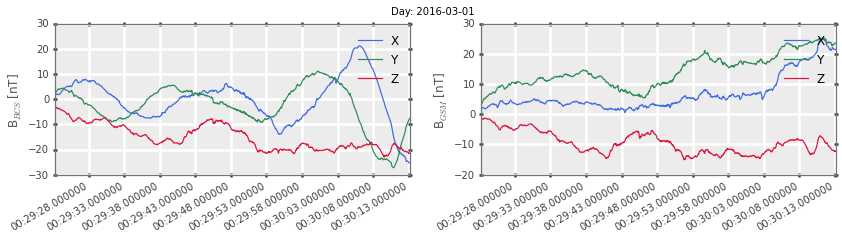

In [20]:
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(122)
lObj = ax.plot(mmsdata['Epoch'][:npts], field_gsm)
ax.set_ylabel('B$_{GSM}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])

ax = fig.add_subplot(121)
lObj = ax.plot(mmsdata['Epoch'][:npts], fieldsBCS)
ax.set_ylabel('B$_{BCS}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])
plt.subplots_adjust()
fig.suptitle('Day: {0}'.format(mmsdata['Epoch'][0].date().isoformat()))

### This looks reasonable as the rotation from BCS to GSM should largely be around the Z axis

We can do a further, simple check by rotating into DBCS, which should remove any periodicity (as it's the despun version of BCS)

In [21]:
quat_bcs_to_eci = tb.quaternionConjugate(mmsdata['mms1_mec_quat_eci_to_bcs'])
quat_bcs_to_dbcs = tb.quaternionMultiply(mmsdata['mms1_mec_quat_eci_to_dbcs'], quat_bcs_to_eci)

field_dbcs = tb.quaternionRotateVector(quat_bcs_to_dbcs[:npts], fieldsBCS)

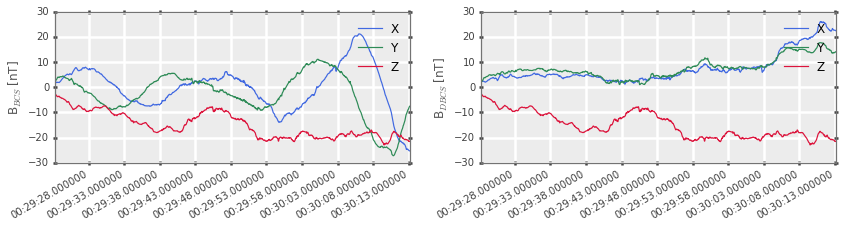

In [22]:
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(122)
lObj = ax.plot(mmsdata['Epoch'][:npts], field_dbcs)
ax.set_ylabel('B$_{DBCS}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])

ax = fig.add_subplot(121)
lObj = ax.plot(mmsdata['Epoch'][:npts], fieldsBCS)
ax.set_ylabel('B$_{BCS}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])
plt.subplots_adjust()

## So let's try a new day and compare with FGM data in different coordinates

These data should be publicly available at the time of writing, so if you don't have the file it will just download.

In [72]:
fname = 'mms1_fgm_brst_l2_20160131234434_v4.18.0.cdf'
if not os.path.isfile(fname):
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, fname])
    urllib.urlretrieve(dataurl, filename=fname)
fgmdata = dm.fromCDF(fname)

In [75]:
fname = 'mms1_mec_brst_l2_epht89d_20160131234435_v2.1.0.cdf'
if not os.path.isfile(fname):
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, fname])
    urllib.urlretrieve(dataurl, filename=fname)
mecdata = dm.fromCDF(fname)

In [76]:
fgmdata.tree()

+
|____Epoch
|____Epoch_state
|____label_b_bcs
|____label_b_dmpa
|____label_b_gse
|____label_b_gsm
|____label_r_gse
|____label_r_gsm
|____mms1_fgm_b_bcs_brst_l2
|____mms1_fgm_b_dmpa_brst_l2
|____mms1_fgm_b_gse_brst_l2
|____mms1_fgm_b_gsm_brst_l2
|____mms1_fgm_bdeltahalf_brst_l2
|____mms1_fgm_etemp_brst_l2
|____mms1_fgm_flag_brst_l2
|____mms1_fgm_hirange_brst_l2
|____mms1_fgm_mode_brst_l2
|____mms1_fgm_r_gse_brst_l2
|____mms1_fgm_r_gsm_brst_l2
|____mms1_fgm_rdeltahalf_brst_l2
|____mms1_fgm_stemp_brst_l2
|____represent_vec_tot


In [77]:
inds = tb.tOverlapHalf(mecdata['Epoch'], fgmdata['Epoch'])
tt = mpd.date2num(mecdata['Epoch'])
fgmtt = mpd.date2num(fgmdata['Epoch'][inds])

fgmBCS = np.empty([len(tt), 3])
fgmBCS[:,0] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_bcs_brst_l2'][inds,0], left=np.nan, right=np.nan)
fgmBCS[:,1] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_bcs_brst_l2'][inds,1], left=np.nan, right=np.nan)
fgmBCS[:,2] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_bcs_brst_l2'][inds,2], left=np.nan, right=np.nan)
fgmmagBCS = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_bcs_brst_l2'][inds,3], left=np.nan, right=np.nan)

In [78]:
fgmGSM = np.empty([len(tt), 3])
fgmGSM[:,0] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gsm_brst_l2'][inds,0], left=np.nan, right=np.nan)
fgmGSM[:,1] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gsm_brst_l2'][inds,1], left=np.nan, right=np.nan)
fgmGSM[:,2] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gsm_brst_l2'][inds,2], left=np.nan, right=np.nan)
fgmmagGSM = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gsm_brst_l2'][inds,3], left=np.nan, right=np.nan)

In [79]:
fgmDMPA = np.empty([len(tt), 3])
fgmDMPA[:,0] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_dmpa_brst_l2'][inds,0], left=np.nan, right=np.nan)
fgmDMPA[:,1] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_dmpa_brst_l2'][inds,1], left=np.nan, right=np.nan)
fgmDMPA[:,2] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_dmpa_brst_l2'][inds,2], left=np.nan, right=np.nan)
fgmmagDMPA = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_dmpa_brst_l2'][inds,3], left=np.nan, right=np.nan)

In [80]:
fgmGSE = np.empty([len(tt), 3])
fgmGSE[:,0] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gse_brst_l2'][inds,0], left=np.nan, right=np.nan)
fgmGSE[:,1] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gse_brst_l2'][inds,1], left=np.nan, right=np.nan)
fgmGSE[:,2] = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gse_brst_l2'][inds,2], left=np.nan, right=np.nan)
fgmmagGSE = tb.interpol(tt, fgmtt, fgmdata['mms1_fgm_b_gse_brst_l2'][inds,3], left=np.nan, right=np.nan)

In [81]:
q_bcs_to_gse = tb.quaternionMultiply(mecdata['mms1_mec_quat_eci_to_gse'], q_bcs_to_eci)

myGSE = tb.quaternionRotateVector(q_bcs_to_gse, fgmBCS)

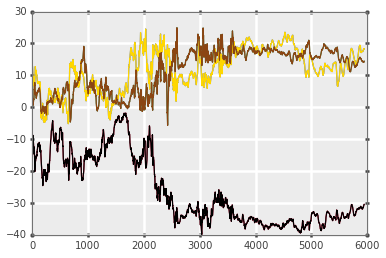

In [82]:
plt.plot(myGSE)
plt.plot(fgmGSE)

In [63]:
mymag = np.array([tb.hypot(rr) for rr in myGSE])

In [65]:
(mymag-fgmmagGSE)[:20]


array([             nan,  -5.98328843e-05,  -7.62545781e-06,
        -1.04335507e-04,  -2.05368739e-05,  -9.85280281e-06,
        -6.43266393e-05,  -2.24541857e-04,  -1.42793935e-03,
        -8.11507326e-05,  -4.35030199e-05,  -1.20068450e-04,
        -5.57254216e-05,  -6.02121570e-04,  -5.94347101e-05,
        -1.50637042e-04,  -1.21454366e-04,  -1.52772447e-04,
        -7.01373950e-06,  -1.06899614e-05])

In [43]:
(mymag-fgmmagBCS)[:20]

array([             nan,  -5.98328843e-05,  -7.62545781e-06,
        -1.04335507e-04,  -2.05368739e-05,  -9.85280282e-06,
        -6.43266393e-05,  -2.24541857e-04,  -1.42793935e-03,
        -8.11507326e-05,  -4.35030199e-05,  -1.20068450e-04,
        -5.57254216e-05,  -6.02121570e-04,  -5.94347101e-05,
        -1.50637042e-04,  -1.21454366e-04,  -1.52772447e-04,
        -7.01373951e-06,  -1.06899614e-05])

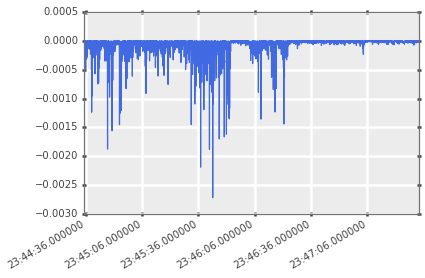

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mecdata['Epoch'], mymag-fgmmagDMPA)
fig.autofmt_xdate()


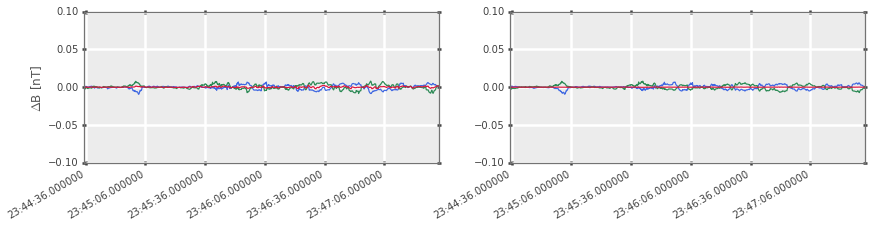

In [87]:
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(121)
ax.plot(mecdata['Epoch'], myGSE-fgmGSE)
ax.set_ylim([-0.1,0.1]) #set y-range to show 0.1nT
ax.set_ylabel('$\Delta$B [nT]')
fig.autofmt_xdate()

ax2 = fig.add_subplot(122)
ax2.plot(mecdata['Epoch'], myDMPA-fgmDMPA)
ax2.set_ylim([-0.1,0.1])
fig.autofmt_xdate()

